In [1]:
out = !pip install ipywidgets
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev

'cuda'

In [2]:
dataset = ImageFolder('./dataset/CelebA-HQ-img', transform=Compose([
    Resize((128, 128)),
    ToTensor()
]))
BS = 16
dtld = DataLoader(dataset, batch_size=BS, shuffle=True, drop_last=True)
a = next(iter(dtld))[0]

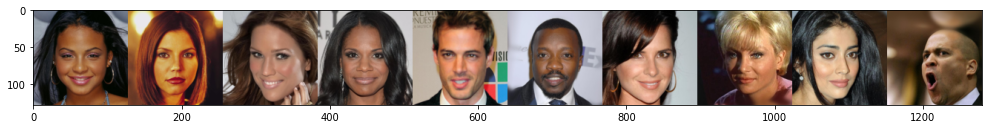

In [3]:
def plot_imgs(imgs, max_imgs=10, losses=False, save=False):
    imgs = imgs.detach().cpu()
    imgs = imgs[:max_imgs].movedim((0, 2, 3, 1), (0, 1, 2, 3)).numpy()
    img = np.concatenate(imgs, axis=1)
    
    fig, axs = plt.subplots(1 + losses)
    fig.set_size_inches((17, 6))
    if losses:
        axs[0].plot(g_losses, label='Generator losses')
        axs[0].plot(d_losses, label='Discriminator losses')
        axs[0].legend()
        axs[1].imshow(img)
    else:
        axs.imshow(img)
    if save:
        fig.savefig(f'./images/epoch_{epoch}')
    plt.show()
plot_imgs(a)

In [4]:
def load():
    try:
        checkpoint = torch.load('./checkpnts/current.pt')
        last_epoch = checkpoint['epoch']
        g.load_state_dict(checkpoint['g_state_dict'])
        d.load_state_dict(checkpoint['d_state_dict'])
        g_losses = checkpoint['g_losses']
        d_losses = checkpoint['d_losses']

        return last_epoch, g_losses, d_losses
    except FileNotFoundError:
        return -1, [], []
        

def save():
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, f'./checkpnts/epoch_{epoch}.pt')
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, './checkpnts/current.pt')

In [5]:
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape, torch.cuda.memory_allocated() / 1e9)
        return x

In [6]:
class MappingNet(nn.Module):
    def __init__(self):
        super(MappingNet, self).__init__()
        self.norm = nn.BatchNorm1d(512)
        self.linear = nn.Sequential(*[nn.Linear(512, 512) for _ in range(8)])
        
    def forward(self, x):
        x = self.norm(x)
        return self.linear(x)


class AdaIN(nn.Module):
    def __init__(self, num_features):
        super(AdaIN, self).__init__()
        self.channels = num_features
        self.norm = nn.InstanceNorm2d(num_features)

    def forward(self, x, y):
        y_std = y[:, 0].view(-1, self.channels, 1, 1)
        y_avg = y[:, 1].view(-1, self.channels, 1, 1)
        return  y_std * self.norm(x) + y_avg


class NoiseLayer(nn.Module):
    def __init__(self, channels):
        super(NoiseLayer, self).__init__()
        self.scaled = nn.Parameter(torch.zeros((channels, 1, 1), device=dev))

    def forward(self, x):
        return x + torch.randn(x.shape, device=dev) * self.scaled


class InputBlock(nn.Module):
    def __init__(self, channels):
        super(InputBlock, self).__init__()
        self.affine1 = nn.Linear(512, 2*channels)
        self.affine2 = nn.Linear(512, 2*channels)

        self.channels = channels
        self.const_noise = nn.Parameter(
            (torch.randn(channels, 4, 4) * 0.1)
        )

        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
        self.noise1 = NoiseLayer(channels)
        self.noise2 = NoiseLayer(channels)
        self.adain1 = AdaIN(channels)
        self.adain2 = AdaIN(channels)
        self.nonlin = nn.ReLU(inplace=True)

    def forward(self, w):
        bs = w.size(0)
        style1 = self.affine1(w).view(bs, 2, -1)
        style2 = self.affine2(w).view(bs, 2, -1)
        x = torch.stack([self.const_noise] * bs)
        x = self.noise1(x)
        x = self.nonlin(x)
        x = self.adain1(x, style1)

        x = self.conv(x)
        x = self.noise2(x)
        x = self.nonlin(x)
        return self.adain2(x, style2)


class SynBlock(nn.Module):
    def __init__(self, channels, out_channels=None):
        super(SynBlock, self).__init__()
        if out_channels is None:
            out_channels = channels // 2
        self.affine1 = nn.Linear(512, 2*channels)
        self.affine2 = nn.Linear(512, 2*out_channels)

        self.up = nn.Upsample(scale_factor=(2, 2))
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, out_channels, 3, padding=1)
        self.noise1 = NoiseLayer(channels)
        self.noise2 = NoiseLayer(out_channels)
        self.adain1 = AdaIN(channels)
        self.adain2 = AdaIN(out_channels)
        self.nonlin = nn.ReLU(inplace=True)

    def forward(self, x, w):
        bs = w.size(0)
        style1 = self.affine1(w).view(bs, 2, -1)
        style2 = self.affine2(w).view(bs, 2, -1)
        x = self.up(x)
        x = self.conv1(x)
        x = self.noise1(x)
        x = self.nonlin(x)
        x = self.adain1(x, style1)

        x = self.conv2(x)
        x = self.noise2(x)
        x = self.nonlin(x)
        return self.adain2(x, style2)


class SynthesisNet(nn.Module):
    def __init__(self, n_blocks, latent_dim):
        super(SynthesisNet, self).__init__()
        self.n_blocks = n_blocks
        self.input_block = InputBlock(latent_dim)

        # dim = latent_dim
        self.blocks = [
            # SynBlock(512, 512).to(dev),
            # SynBlock(512, 512).to(dev),
            SynBlock(512).to(dev),
            SynBlock(256, 256).to(dev),
            SynBlock(256).to(dev),
            SynBlock(128).to(dev),
            SynBlock(64).to(dev),
            # SynBlock(32).to(dev)
        ]
        # for block in range(1, n_blocks):
        #     self.blocks.append(SynBlock(dim).to(dev))
        #     dim //= 2
        self.non_lin = nn.Sigmoid()
        self.rgb_conv = nn.Conv2d(32, 3, 1)
        for i, block in enumerate(self.blocks):
            self.add_module(f'SynBlock [{i+1}]', block)

    def forward(self, w):
        x = self.input_block(w)
        for n, block in enumerate(self.blocks):
            x = block(x, w)
            
        x = self.rgb_conv(x)
        return self.non_lin(x)


class Generator(nn.Module):
    def __init__(self, latent_dim=512, n_blocks=9):
        super(Generator, self).__init__()
        self.mapnet = MappingNet()
        self.synnet = SynthesisNet(n_blocks, latent_dim)
        self.latent_dim = latent_dim
        self.n_blocks = n_blocks

    def forward(self, bs):
        z = torch.randn((bs, self.latent_dim), device=dev)
        w = self.mapnet(z)
        return self.synnet(w)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_c, out_c):
            return [
                nn.utils.spectral_norm(
                    nn.Conv2d(in_c, out_c, 3, padding=1),
                ),
                nn.LeakyReLU(inplace=True),
                nn.utils.spectral_norm(
                    nn.Conv2d(out_c, out_c, 3, padding=1),
                ),
                nn.LeakyReLU(inplace=True),
                nn.BatchNorm2d(out_c),
                nn.AvgPool2d(2),
            ]

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 1),
            nn.LeakyReLU(),
            # *block(16, 32),
            *block(32, 64),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            *block(512, 512),
            # *block(512, 512),
            # *block(512, 512),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 512, 4, bias=False),
            nn.LeakyReLU(inplace=True),
        )
        self.flat = nn.Flatten()
        self.l1 = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        return self.l1(x)


g = Generator().to(dev)
d = Discriminator().to(dev)
g(BS).shape
d(g(BS)).shape

torch.Size([16, 1])

In [7]:
gp = sum(dict((p.data_ptr(), p.numel()) for p in g.parameters()).values())
dp = sum(dict((p.data_ptr(), p.numel()) for p in d.parameters()).values())
print(f'Generators params: {gp / 1e6:.2f}M, Discrminator params: {dp / 1e6:.2f}M')

Generators params: 13.41M, Discrminator params: 15.98M


In [8]:
def train_loop(dtld):
    for i, (x, _) in enumerate(t := tqdm(dtld)):
        x = x.to(dev)

        ones, zeros = torch.full([BS], .9, device=dev), torch.zeros((BS), device=dev)
        gen_imgs = g(BS)
        
        # Train generator
        for p in g.parameters():
            p.grad = None
        y_hat = d(gen_imgs).reshape((-1))
        g_loss = g_crit(y_hat, ones)
        g_loss.backward()
        g_optim.step()

        # Train discriminator
        for p in d.parameters():
            p.grad = None
        ones_hat, zeros_hat = d(x).reshape((-1)), d(gen_imgs.detach()).reshape((-1))
        d_loss = (d_crit(ones_hat, ones) + d_crit(zeros_hat, zeros)) / 2
        d_loss.backward()
        d_optim.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        t.set_description(f'G loss: {g_losses[-1]:.4f}, D loss: {d_losses[-1]:.4f}, Mem used: {torch.cuda.memory_allocated() / 1e9: .4f}')
        if i % (len(dtld) // 4) == 0:
            save()

  0%|          | 0/37 [00:00<?, ?it/s]

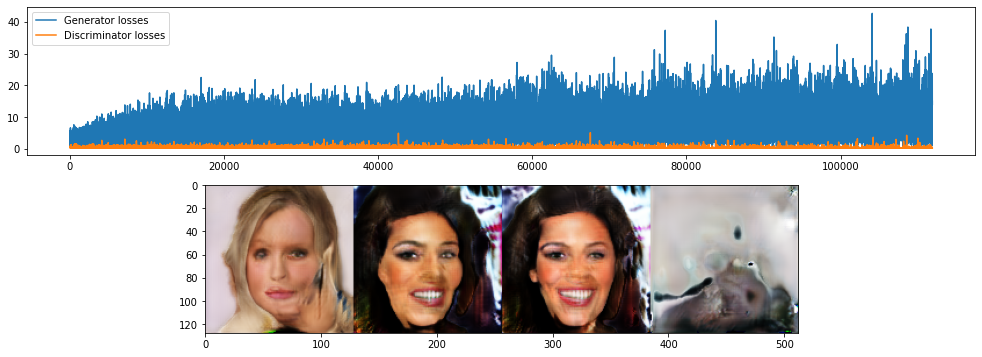

  0%|          | 0/1875 [00:00<?, ?it/s]

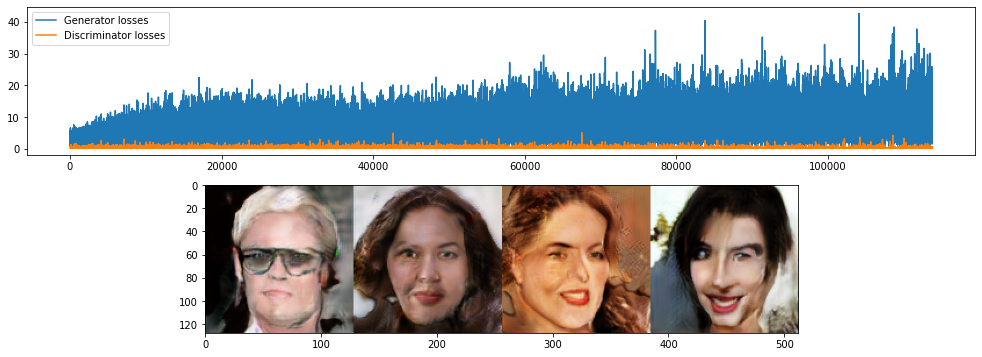

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
g_crit = nn.BCELoss()
d_crit = nn.BCELoss()
g_optim = torch.optim.Adam(g.parameters(), lr=2e-5, betas=(.5, .999))
d_optim = torch.optim.Adam(d.parameters(), lr=2e-5, betas=(.5, .999))
epochs = 100
last_epoch, g_losses, d_losses = load()

for epoch in trange(last_epoch + 1, epochs):
    plot_imgs(g(4), losses=True, save=True)
    train_loop(dtld)
    save()